# Chapter 6

In [42]:
import matplotlib.pyplot as plt
import arviz as az
import pymc3 as pm
import scipy.stats as stats
import numpy as np
import theano.tensor as tt
import pandas as pd

## Exercise 1

In [43]:
vals = stats.norm.rvs(loc=[10,20,30], scale=1, size=(100,3)).flatten()
vals[:5]

array([ 8.96589444, 19.12713595, 29.87390053,  8.37124919, 21.26765451])

Let's plot a kde plot to see what things look like

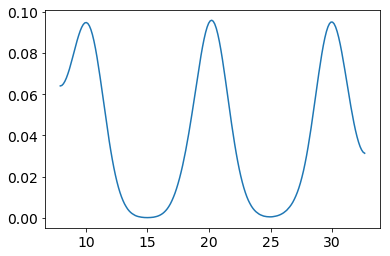

In [44]:
az.plot_kde(vals)

### Fit 2, 3, and 4 component mixture models

In [45]:
clusters = [2,3,4]
traces = {}
for cluster in clusters:
    with pm.Model() as two_components:
        p = pm.Dirichlet("p", a=np.ones(cluster))

        # Each mean of the mixture data has its own estimate of a mean with a fixed SD in this case
        means = pm.Normal("means", mu= vals.mean(), sd=10, shape=cluster)
        
        # Estimate of the standard deviation of what?
        sd = pm.HalfCauchy("sd", 1)
        y = pm.NormalMixture("y", w=p, mu=means, sd=sd, observed=vals)
        
        trace = pm.sample(random_seed=123)
        traces[f"Cluster Size {cluster}"] = az.from_pymc3(trace=trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1511.97draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1291.18draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:11<00:00, 340.30dr

# Exercise 2

In [46]:
comparison = az.compare(traces)
comparison

,waic,pwaic,dwaic,weight,se,dse,warning
Cluster Size 3,1532.32,6.083,0,1,25.2436,0,0
Cluster Size 4,1532.45,6.15367,0.134163,0,25.2293,0.265902,0
Cluster Size 2,2066.36,3.01461,534.041,0,4.71745,25.0408,0


In [47]:
az.loo(traces["Cluster Size 2"])

,loo,loo_se,p_loo,warning
0,2066.360967,4.717458,3.014777,0


In [48]:
az.loo(traces["Cluster Size 3"])

,loo,loo_se,p_loo,warning
0,1532.32812,25.244902,6.087236,0


In [49]:
az.loo(traces["Cluster Size 4"])

,loo,loo_se,p_loo,warning
0,1532.466599,25.232117,6.160062,0


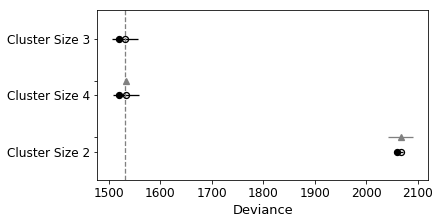

In [50]:
az.plot_compare(comparison)

### Ask about this
When we have four chains why does the MCMC algorithm have so much trouble converging? Is it the starting points and each chain gets stuck in one? 

Alternatively asked why isn't there just an indentifiability problem?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f175a39f6d8>,
      dtype=object)

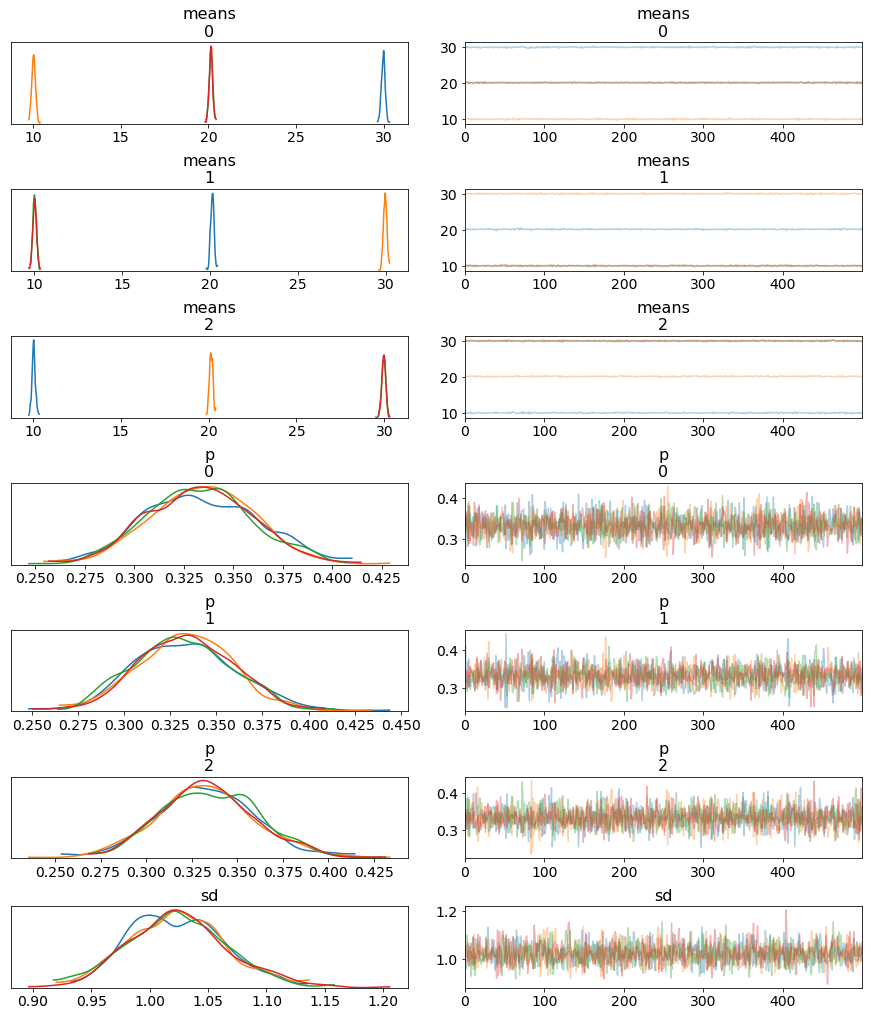

In [51]:
az.plot_trace(traces["Cluster Size 3"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1767f7df28>,
      dtype=object)

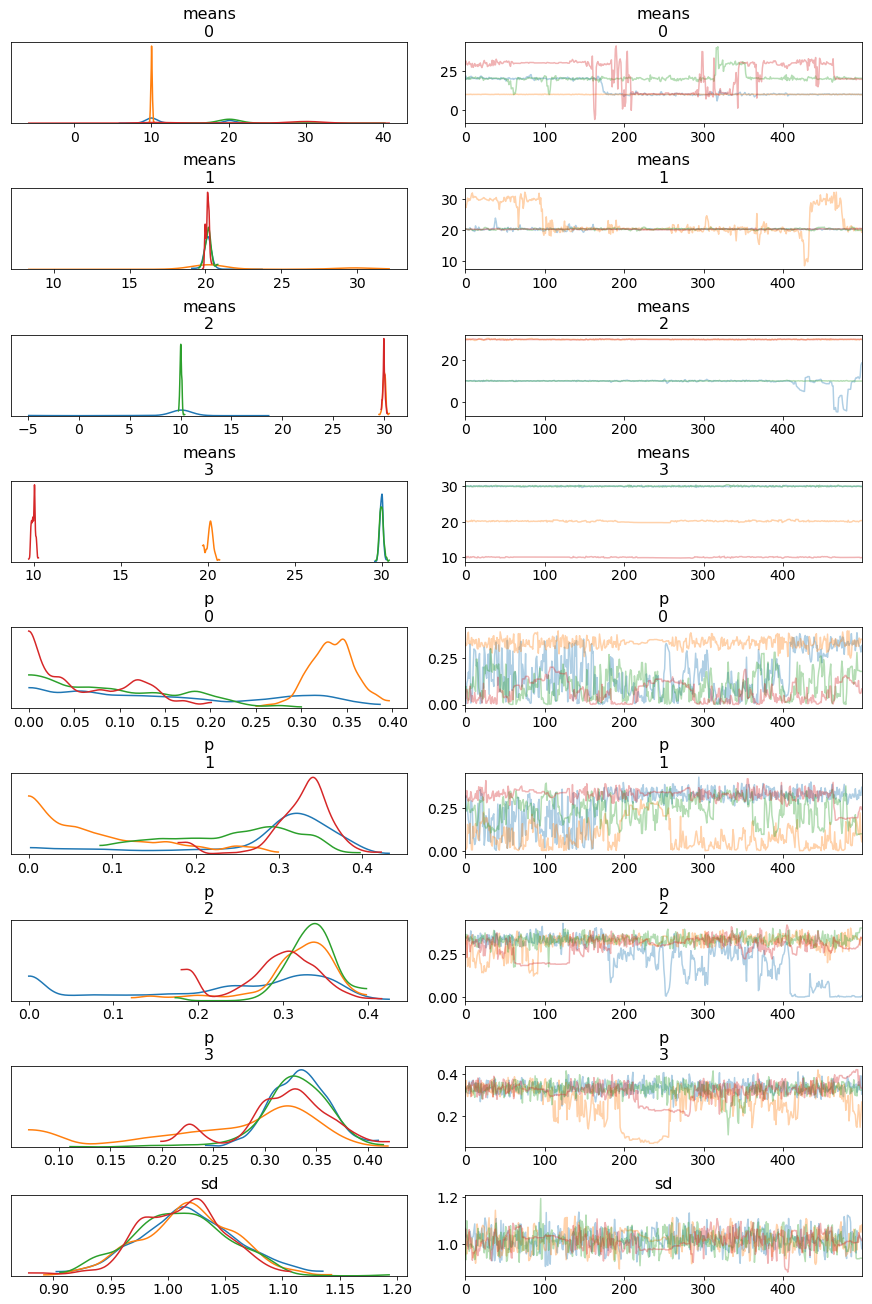

In [52]:
az.plot_trace(traces["Cluster Size 4"])

## Exercise 4

In [53]:
K=20

def stick_breaking(α, K):
    β = pm.Beta('β', 1., α, shape=K)
    w = β * pm.math.concatenate([[1.], tt.extra_ops.cumprod(1. - β)[:-1]])
    return w

In [54]:
print(K)
with pm.Model() as model:
    α = pm.Gamma('α', 1, 1.)
    w = pm.Deterministic('w', stick_breaking(α, K))
    means = pm.Normal('means',
                      mu=np.linspace(vals.min(), vals.max(), K),
                      sd=1, shape=K)
    sd = pm.HalfNormal('sd', sd=1, shape=K)
    
    obs = pm.NormalMixture('obs', w, means, sd=sd, observed=vals)
    trace = pm.sample(10000, tune=5000, nuts_kwargs={'target_accept':0.85})

20


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, β, α]
Sampling 4 chains: 100%|██████████| 60000/60000 [02:38<00:00, 377.52draws/s]
The chain contains only diverging samples. The model is probably misspecified.
There were 9940 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9989 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9997 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


## Exercise 5

In [55]:
iris = pd.read_csv('../code/data/iris.csv')
sepal_length = iris["sepal_length"].values

In [56]:
clusters = 3
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means', mu=sepal_length.mean(), sd=10, shape=clusters)
    
    sd = pm.HalfNormal('sd', sd=10)
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=sepal_length)
    sepal_trace = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]
Sampling 4 chains: 100%|██████████| 28000/28000 [00:40<00:00, 685.96draws/s]
The acceptance probability does not match the target. It is 0.91301539877164, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.33386745047884786, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f175bf5d7f0>,
      dtype=object)

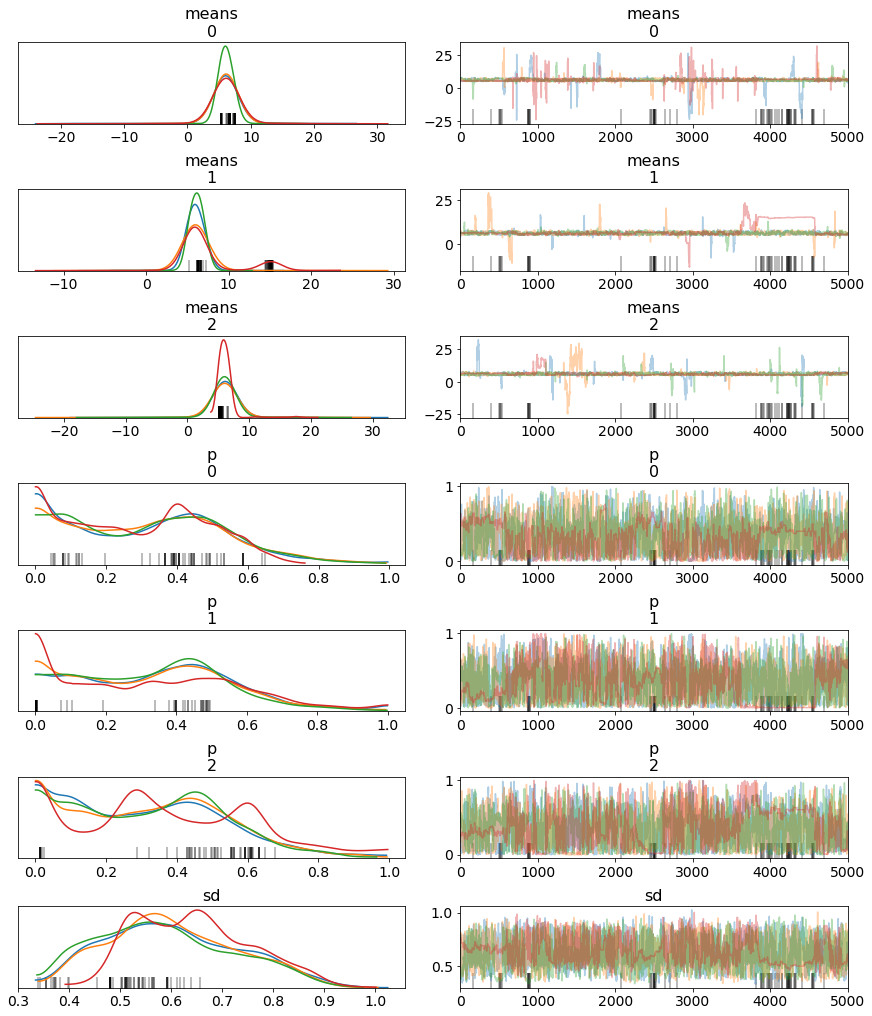

In [57]:
az.plot_trace(sepal_trace)

## Exercise 6

In [58]:
iris = pd.read_csv('../code/data/iris.csv')
sepal_length = iris["sepal_length"].values
sepal_width = iris["sepal_width"].values

In [59]:
clusters = 3
with pm.Model() as model_mg:
    # Sepal Width
    p_sepal_width = pm.Dirichlet('p_sepal_width', a=np.ones(clusters))
    means_sepal_width = pm.Normal('means_sepal_width', mu=sepal_width.mean(), sd=10, shape=clusters)
    sd_sepal_width = pm.HalfNormal('sd_sepal_width', sd=1)
    sepal_width_y = pm.NormalMixture('sepal_width_y', w=p_sepal_width, mu=means_sepal_width, sd=sd_sepal_width, observed=sepal_width)
    
    # Sepal length
    p_sepal_length = pm.Dirichlet('p_sepal_length', a=np.ones(clusters))
    means_sepal_length = pm.Normal('means_sepal_length', mu=sepal_length.mean(), sd=10, shape=clusters)
    sd_sepal_length = pm.HalfNormal('sd_sepal_length', sd=1)
    sepal_length_y = pm.NormalMixture('sepal_length_y', w=p_sepal_length, mu=means_sepal_length, sd=sd_sepal_length, observed=sepal_length)
    
    
    sepal_length_width_trace = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_sepal_length, means_sepal_length, p_sepal_length, sd_sepal_width, means_sepal_width, p_sepal_width]
Sampling 4 chains: 100%|██████████| 28000/28000 [03:18<00:00, 141.30draws/s]
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.21545225597726744, but should be close to 0.8. Try to increase the number of tuning steps.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5666285655445203, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for so

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1781f58b00>,
      dtype=object)

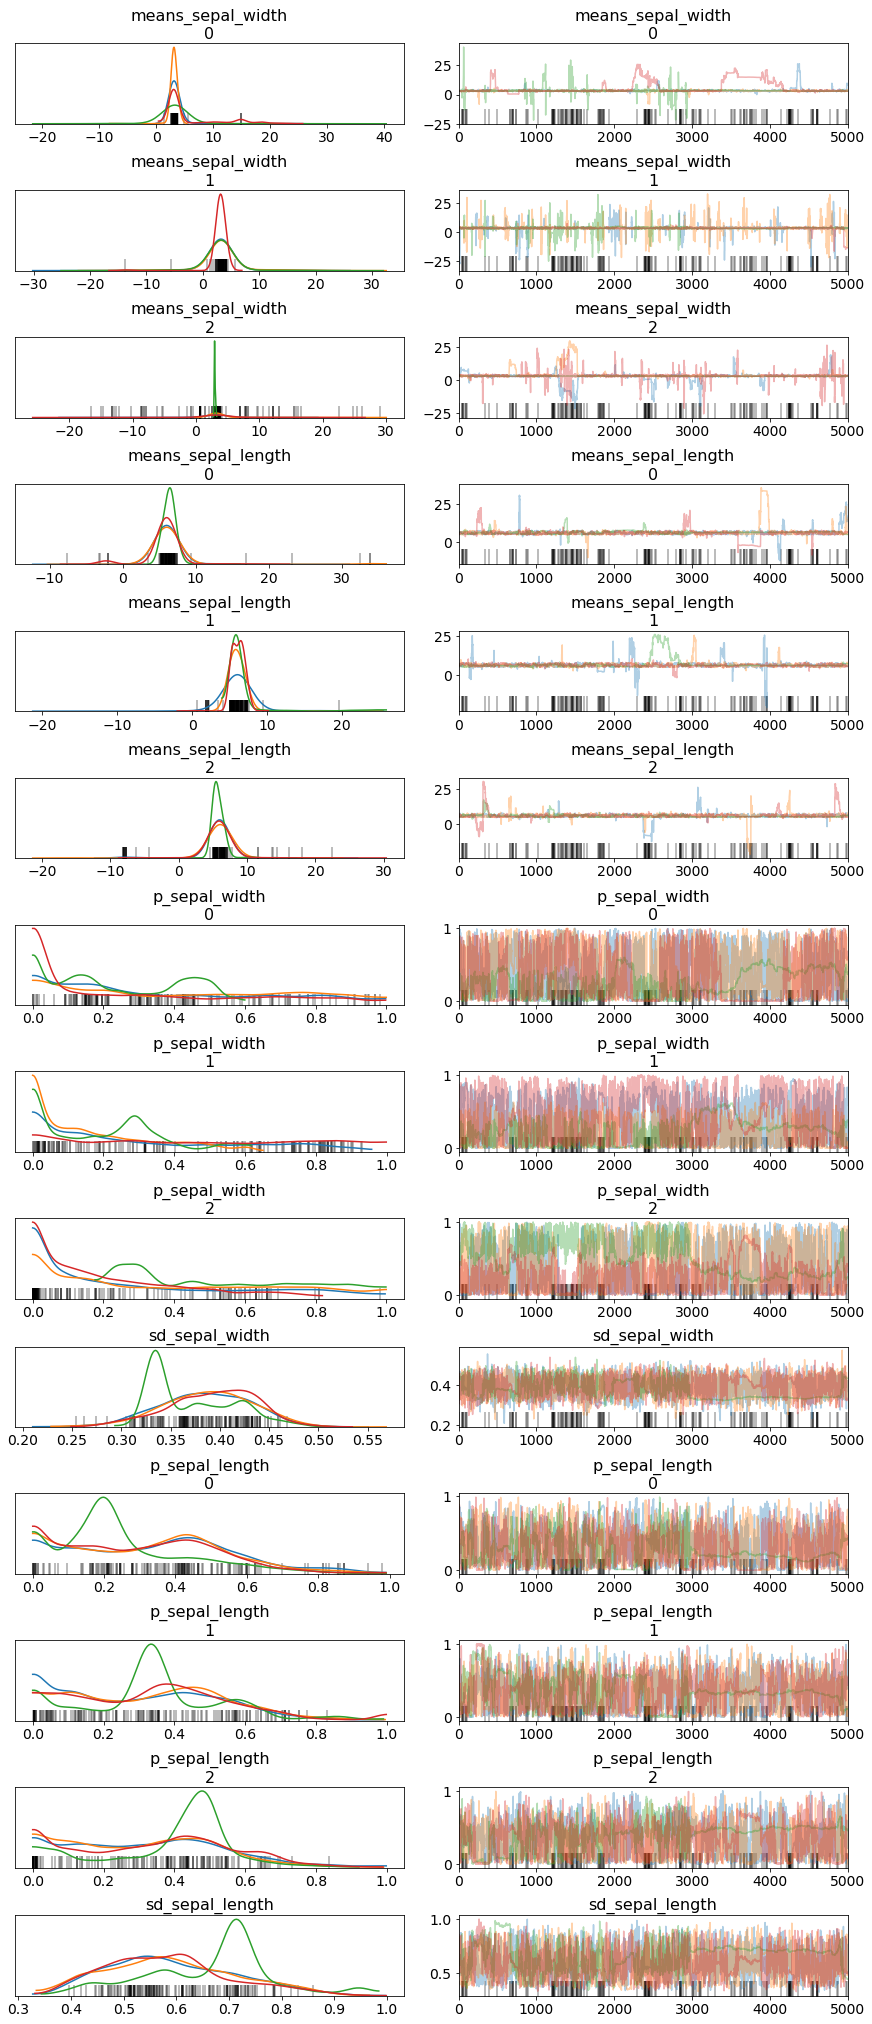

In [60]:
az.plot_trace(sepal_length_width_trace)